In [1]:
%matplotlib inline


# CSCIE 81 Machine Learning Homework 3

Lu Wang, Ram Ochoa 


In [51]:
print(__doc__)
import operator 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
#from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA


Automatically created module for IPython interactive environment


### Loading and pre-processing data

To begin with, I replaced NA's with zeros. 

Later, I will see how many features were mostly "NA". If they are not important, I will probably drop them. 

I'm creating two arrays: one to store how many NAs were in each feature, and the other to store how many NAs were in each observation. 

In [3]:
NA_counts_per_feature = []
for i in range(0, 334): 
    NA_counts_per_feature.append(0)

NA_counts_per_observation = [] 
for i in range(0, 17379): 
    NA_counts_per_observation.append(0)

### Load data in and replace NA->0 
trainX = [] 
with open("/home/lu/Documents/School/81_machine_learning/HW3/HW3/trainingData.txt", 'r') as rp: 
    row_i = 0 
    for line in rp.read().split("\n"): 
        row = line.split("\t") 
        column_i = 0 # cell index 
        for cell in row: 
            try: 
                row[column_i] = float(cell)
            except ValueError: 
                row[column_i] = 0 
                NA_counts_per_feature[column_i]+=1 
                NA_counts_per_observation[row_i]+=1 
            column_i+=1  
        row_i +=1 
        trainX.append(row)
        
trainY = [] 
with open("/home/lu/Documents/School/81_machine_learning/HW3/HW3/trainingTruth.txt", 'r') as rp: 
    for line in rp.read().split("\n"): 
        trainY.append(line)

The max number of NAs in a column is 81, and 334 columns are missing data. The max number of NAs in a row is 7, and 11620 rows are missing data. 

This suggests that there aren't that many missing values per column. My worry that replacing them with zero might affect the model's predictive power. I could replace the missing values with the average of all of the columns. 

The max number of NAs in a column is 81, and 334 columns are missing data
The max number of NAs in a row is 7, and 11620 rows are missing data


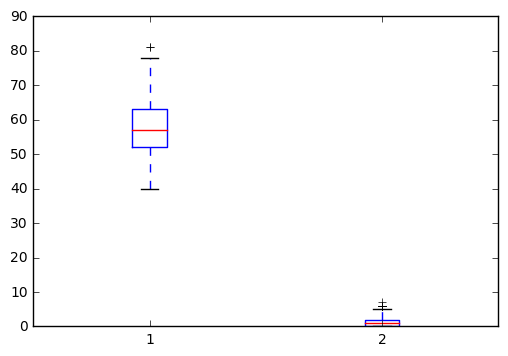

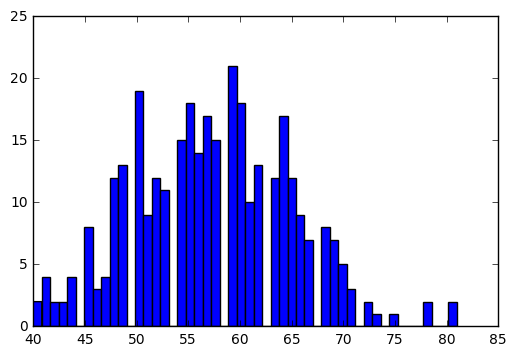

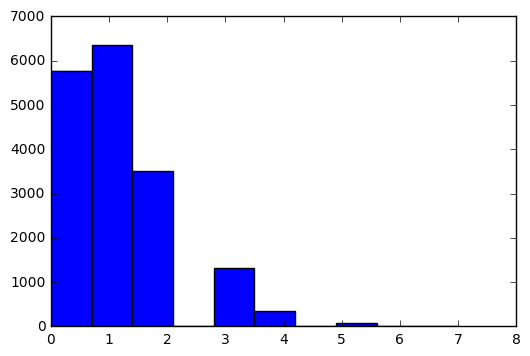

In [4]:
import numpy as np 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

### These arrays are the counts of NAs that were filled per feature , or per data entry 
NA_per_feature = np.array(NA_counts_per_feature)
NA_per_observation = np.array(NA_counts_per_observation)

count_of_columns_with_NAs = len([x for x in NA_counts_per_feature if x > 0 ])
count_of_rows_with_NAs = len([x for x in NA_per_observation if x > 0 ])

print("The max number of NAs in a column is %d, and %d columns are missing data" % (max(NA_per_feature), count_of_columns_with_NAs))
print("The max number of NAs in a row is %d, and %d rows are missing data" % (max(NA_per_observation), count_of_rows_with_NAs)) 

data_to_plot = [NA_per_feature, NA_per_observation]

plt.boxplot(data_to_plot)
plt.show() 

n, bins, patches = plt.hist(NA_per_feature, 50)
plt.show() 
n, bins, patches = plt.hist(NA_per_observation, 10)
plt.show() 

From the plots, it looks like while more than half the rows are only missing a couple datapoints, the NA's are shared amoung all the features. The features missing the most entries are still missing 25 datapoints or fewer, less than 0.1% of the total. It doesn't make sense to remove features or all rows missing datapoints. We'd have little to no data left... 

Instead, let's try replacing the missing values with the average of the feature. Then, I'll compare the performance of models ran on NA->0 vs NA->feature mean. 

In [5]:
### Sample some entries from the X data set 
sampleX = np.array(trainX[0:1000])

### Calculate an array of means 
feature_means = np.mean(sampleX, axis=0)

trainX_mean = [] 
with open("/home/lu/Documents/School/81_machine_learning/HW3/HW3/trainingData.txt", 'r') as rp: 
    for line in rp.read().split("\n"): 
        row = line.split("\t") 
        column_i = 0 # cell index 
        for cell in row: 
            try: 
                row[column_i] = float(cell)
            except ValueError: 
                row[column_i] = feature_means[column_i]
            column_i+=1  
        trainX_mean.append(row)
        
trainY_mean = [] 
with open("/home/lu/Documents/School/81_machine_learning/HW3/HW3/trainingTruth.txt", 'r') as rp: 
    for line in rp.read().split("\n"): 
        trainY_mean.append(line)



### Trying some models with zero-filled and mean-filled data 

For this first pass, try with a subset of our data, and try a LOT of models. I kept adding to this list after hearing more about new models.

In [6]:
arrayX = np.array(trainX[0:17377])
arrayY = np.array(trainY[0:17377])
arrayXm = np.array(trainX_mean[0:17377])

X_train, X_test, y_train, y_test = train_test_split(arrayX, arrayY, test_size=0.4, random_state=0)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(arrayXm, arrayY, test_size=0.4, random_state=0)

print(len(arrayX),len(arrayXm))
print(len(arrayX[0]),len(arrayXm[0]))

17377 17377
334 334


In [7]:
classifiers = [
#    ["Nearest Neighbors", KNeighborsClassifier(3)],
    ["Linear SVM", SVC(kernel='linear', C=0.5)],
#    ["RBF SVM", SVC(gamma=2, C=1)],
    ["DecisionTree1", DecisionTreeClassifier(max_depth=5)], 
    ["RandomForest1", RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)],
    ["DecisionTree2", DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=20, random_state=0)],
    ["Rand Forest2", RandomForestClassifier(n_estimators=30, criterion='entropy', max_depth=20, min_samples_leaf=20, 
                           bootstrap=True, oob_score=False, random_state=0 )],
#    ["Adaboost", AdaBoostClassifier()],
    ["GaussianNB", GaussianNB()],
    ["Logit", LogisticRegression(C=1)], 
    ["Logit l=2", LogisticRegression(C=2)], 
    ["Logit l=4", LogisticRegression(C=4)],
#    ["QDA", QuadraticDiscriminantAnalysis()]
]
print("Classifier | Score on Test NA=0 | Score on Train NA=0 | Score on Test NA=mean | Score on Train NA=mean |")
print("--- | --- | --- | --- | --- | ")

results = [] 

for name, classifier in  classifiers : 
    clf=classifier
    clfm=classifier
    clf.fit(X_train, y_train)
    clfm.fit(Xm_train, ym_train)
    row = [ name, 
            clf.score(X_test, y_test) ,clf.score(X_train, y_train), #comparing test and training on 4/6 split
            clfm.score(Xm_test, ym_test) ,clfm.score(Xm_train, ym_train)
         ]
    print(name + "|" + "|".join(["%.3f" % x for x in row[1:]]) )
    results.append(row)
    

Classifier | Score on Test NA=0 | Score on Train NA=0 | Score on Test NA=mean | Score on Train NA=mean |
--- | --- | --- | --- | --- | 
Linear SVM|0.756|0.820|0.757|0.819
DecisionTree1|0.465|0.511|0.465|0.511
RandomForest1|0.429|0.465|0.429|0.465
DecisionTree2|0.465|0.511|0.466|0.512
Rand Forest2|0.614|0.771|0.615|0.772
GaussianNB|0.771|0.795|0.772|0.796
Logit|0.765|0.794|0.766|0.795
Logit l=2|0.765|0.794|0.766|0.794
Logit l=4|0.765|0.795|0.766|0.795


In [8]:
resultsdf = pd.DataFrame(results) 
difference = resultsdf[3]-resultsdf[1]
resultsdf["gain from NA=mean"]=difference
resultsdf = resultsdf.sort_values(by=1,ascending=False)
resultsdf.columns = ["Classifier", "NA=0 Test", "Training", "NA=mean Test", "Training", "gains from NA=mean"] 
resultsdf

,Classifier,NA=0 Test,Training,NA=mean Test,Training,gains from NA=mean
5,GaussianNB,0.770680,0.795319,0.771831,0.795991,0.001151
6,Logit,0.765214,0.794264,0.765501,0.794552,0.000288
7,Logit l=2,0.765070,0.793977,0.765933,0.793785,0.000863
8,Logit l=4,0.764782,0.794744,0.765501,0.794744,0.000719
0,Linear SVM,0.755719,0.819682,0.756870,0.819298,0.001151
4,Rand Forest2,0.613869,0.770669,0.615163,0.772012,0.001295
1,DecisionTree1,0.465401,0.510838,0.465257,0.511030,-0.000144
3,DecisionTree2,0.464825,0.511222,0.465688,0.512373,0.000863
2,RandomForest1,0.428571,0.465087,0.428571,0.464608,0.000000


### Assessment of list of models after NA treatment 

First, there seem to be modest gains from replacing the NAs with means. 

From this sample run, it looks like for Naive Bayes, Logit, and SVM, we are in **high variance, low bias** state. We should add more data, reduce the feature space using methods like PCA/LDA, and increase lambda. 

Nearest Neighbors, the Trees, and Adaboost are suffering from **high bias, high variance**. Not only is the model predicting poorly on the test data, it is struggling to classify the training data. Whatever the model is learning is wrong. All of the above improvements should be applied, but we should also try to add more complexity to the models, add high order terms, and allow more high-order features to remaing by reducing the lambda in regularization. 


### Next Steps

* Check that the label counts are balanced. I didn't double check if our outputs are unbalanced - if that's the case, we might wrongly prioritize the most common outcome and create bias. 
* Reduce dimensions
* Try different lambdas and kernels 
* Rerun the panel of models after each change, and at the end drop the worst half 

In [9]:
Ydf = pd.DataFrame(arrayY)
Ycounts=Ydf.groupby([0]).size()
Ycounts

0
1    5666
2    3893
3    5217
4    2601
dtype: int64

### Balancing dataset 

Indeed the classes are not equal. I'm not sure if 17K is too big for over-sampling or too small for under-sampling, so I think I'd like to try both: to sample with replacement until all classes have 5666 records, or to sample 2601 from all classes. 

In [10]:
### join the data to keep X and Y together 

Ydf = pd.DataFrame(trainY)
Ydf.columns = ['label']
Xdf = pd.DataFrame(trainX_mean)
XYdf = Xdf.join(Ydf)[0:17377]


undersize = 2601 
underXYdf = pd.concat([
    XYdf[XYdf['label']=='1'].sample(undersize),
    XYdf[XYdf['label']=='2'].sample(undersize),
    XYdf[XYdf['label']=='3'].sample(undersize),
    XYdf[XYdf['label']=='4'].sample(undersize)
        ])


oversize = 5666 
overXYdf = pd.concat([
    XYdf[XYdf['label']=='1'].sample(oversize, replace=True),
    XYdf[XYdf['label']=='2'].sample(oversize, replace=True),
    XYdf[XYdf['label']=='3'].sample(oversize, replace=True),
    XYdf[XYdf['label']=='4'].sample(oversize, replace=True),
        ])


overX, overY = overXYdf.ix[:,0:334] , overXYdf['label']

underX, underY = underXYdf.ix[:,0:334] , underXYdf['label']

print(4*undersize)
print(4*oversize)
print(overX.shape, overY.shape)
print(underX.shape, underY.shape)

10404
22664
(22664, 334) (22664,)
(10404, 334) (10404,)


Now, we have two sets of X and Y variables. Let's run through the classifiers again on these samples


In [11]:
X1_train, X1_test, y1_train, y1_test = train_test_split(overX, overY, test_size=0.4, random_state=0)
X2_train, X2_test, y2_train, y2_test = train_test_split(underX, underY, test_size=0.4, random_state=0)

print(overX.shape, overY.shape)
print(X1_train.shape, y1_train.shape)
print(X1_test.shape, y1_test.shape)

(22664, 334) (22664,)
(13598, 334) (13598,)
(9066, 334) (9066,)


In [12]:
classifiers = [
   # ["Nearest Neighbors", KNeighborsClassifier(3)],
    ["Linear SVM", SVC(kernel='linear', C=0.5)],
#    ["RBF SVM", SVC(gamma=2, C=1)],
   # ["DecisionTree1", DecisionTreeClassifier(max_depth=5)], 
   # ["RandomForest1", RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)],
   # ["DecisionTree2", DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=20, random_state=0)],
#    ["Rand Forest2", RandomForestClassifier(n_estimators=30, criterion='entropy', max_depth=20, min_samples_leaf=20, 
#                           bootstrap=True, oob_score=False, random_state=0 )],
   # ["Adaboost", AdaBoostClassifier()],
    ["GaussianNB", GaussianNB()],
    ["Logit", LogisticRegression(C=1)],
    ["Logit l=2", LogisticRegression(C=2)], 
    ["Logit l=4", LogisticRegression(C=4)],
#    ["QDA", QuadraticDiscriminantAnalysis()]
]
print("Classifier | Score on Test oversampled data | Score on Train | Score on Test undersampled data | Score on Train |")
print("--- | --- | --- | --- | --- | ")

results_balancing = [] 

for name, classifier in  classifiers : 
    clf1=classifier
    clf2=classifier
    clf1.fit(X1_train, y1_train)
    clf2.fit(X2_train, y2_train)
    row = [ name, 
            clf1.score(X1_test, y1_test) ,clf1.score(X1_train, y1_train), #comparing test and training on 4/6 split
            clf2.score(X2_test, y2_test) ,clf2.score(X2_train, y2_train)
         ]
    print(name + "|" + "|".join(["%.3f" % x for x in row[1:]]) )
    results_balancing.append(row)

Classifier | Score on Test oversampled data | Score on Train | Score on Test undersampled data | Score on Train |
--- | --- | --- | --- | --- | 
Linear SVM|0.736|0.730|0.668|0.810
GaussianNB|0.752|0.751|0.720|0.779
Logit|0.729|0.729|0.692|0.777
Logit l=2|0.732|0.730|0.691|0.780
Logit l=4|0.733|0.731|0.692|0.781


### Performance with Balanced Classes, over and under sampling 

In [13]:
resultsdf = pd.DataFrame(results_balancing) 
resultsdf = resultsdf.sort_values(by=1,ascending=False)
resultsdf.columns = ["Classifier", "oversampled Test", "Training", "undersampled Test", "Training"] 
resultsdf

,Classifier,oversampled Test,Training,undersampled Test,Training
1,GaussianNB,0.751710,0.751360,0.719846,0.778917
0,Linear SVM,0.736378,0.729666,0.668429,0.810317
4,Logit l=4,0.732848,0.730916,0.692215,0.780519
3,Logit l=2,0.731524,0.729887,0.691494,0.779558
2,Logit,0.729318,0.728931,0.692456,0.777315


Across the board, oversampling performed better. However, when compared to the original dataset using NA substitution techniques, the best 3 models were those using the original dataset. 


### Performance without balancing classes 

Classifier | Score on Test NA=0 | Score on Train NA=0 | Score on Test NA=mean | Score on Train NA=mean |
--- | --- | --- | --- | --- | 
GaussianNB|0.771|0.795|0.772|0.796
Logit|0.765|0.794|0.766|0.795
Linear SVM|0.756|0.820|0.757|0.819


I think the bias is high enough on this data that more data is not helpful. 

At this point, I think we will use the data with NA=feature means and the original obervations. 

Now, because of the high bias, I would like to revisit the features. 334 is a lot of features, and many may be correlated. 


### Feature reduction and transformation

Now, let's continue on the list of things to try. I would like to try to reduce the features using 

* Random forest to find the most significant existing features 
* PCA to transform the features 
* LDA to find eigenvectors to separate the classes 

In [14]:
arrayY = np.array(trainY[0:17377])
arrayX = np.array(trainX_mean[0:17377])

X_train, X_test, y_train, y_test = train_test_split(arrayXm, arrayY, test_size=0.4, random_state=0)


names = ["DT", "RF", "DT10", "DT10"]
feature_importances = { "DT": [] , "RF": [] , "DT10": [] , "RF10": []}
important_indexes = { "DT": [] , "RF": [], "DT10": [] , "RF10": [] }

classifiers = [
    DecisionTreeClassifier(criterion='entropy', max_depth=5,
                           min_samples_split=2, min_samples_leaf=20, 
                           max_features=None,
                           random_state=0, 
                           ),
    RandomForestClassifier(n_estimators=100, criterion='entropy',
                           max_depth=5, min_samples_split=2, 
                           min_samples_leaf=20, 
                           max_features='auto',
                           bootstrap=True, oob_score=False, 
                           random_state=0, 
                           ),
    DecisionTreeClassifier(criterion='entropy', max_depth=10,
                           min_samples_split=2, min_samples_leaf=20, 
                           max_features=None,
                           random_state=0, 
                           ),
    RandomForestClassifier(n_estimators=100, criterion='entropy',
                           max_depth=10, min_samples_split=2, 
                           min_samples_leaf=20, 
                           max_features='auto',
                           bootstrap=True, oob_score=False, 
                           random_state=0, 
                           )
]


for name, classifier in zip(names, classifiers): 
    clf=classifier
    clf.fit(X_train, y_train)
    print("%s accuracy on test: %f" % (name, clf.score(X_test, y_test) ))
    feature_importances[name]=clf.feature_importances_

for name, importances in feature_importances.items(): 
    features = list(enumerate(importances))
    important_indexes[name] = [i for i, v in features if v > 0]


DT accuracy on test: 0.465688
RF accuracy on test: 0.574450
DT10 accuracy on test: 0.454899
DT10 accuracy on test: 0.613149


In [15]:
  
print("""There are %d and %d important features according to 
      decision tree and random forest, respectively. It is expected 
      that random forest will have many more important features, since 
      it is an ensemble method. 
      """ % (len(important_indexes['DT']), len(important_indexes['RF'])))
dtX=arrayX[:,important_indexes['DT']]
rfX=arrayX[:,important_indexes['RF']]

There are 23 and 288 important features according to 
    decision tree and random forest, respectively. It is expected 
    that random forest will have many more important features, since 
    it is an ensemble method. 
    


In [16]:
X1_train, X1_test, y1_train, y1_test = train_test_split(dtX, arrayY, test_size=0.4, random_state=0)
X2_train, X2_test, y2_train, y2_test = train_test_split(rfX, arrayY, test_size=0.4, random_state=0)

print(X1_train.shape, y1_train.shape)
print(X1_test.shape, y1_test.shape)

print(X2_train.shape, y2_train.shape)
print(X2_test.shape, y2_test.shape)


(10426, 23) (10426,)
(6951, 23) (6951,)
(10426, 288) (10426,)
(6951, 288) (6951,)


In [17]:
classifiers = [
    ["Nearest Neighbors", KNeighborsClassifier(3)],
    ["Linear SVM", SVC(kernel='linear', C=0.5)],
    ["RBF SVM", SVC(gamma=2, C=1)],
    ["DecisionTree1", DecisionTreeClassifier(max_depth=5)], 
    ["RandomForest1", RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)],
    ["DecisionTree2", DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=20, random_state=0)],
    ["Rand Forest2", RandomForestClassifier(n_estimators=30, criterion='entropy', max_depth=20, min_samples_leaf=20, 
                           bootstrap=True, oob_score=False, random_state=0 )],
    ["Adaboost", AdaBoostClassifier()],
    ["GaussianNB", GaussianNB()],
    ["Logit", LogisticRegression(C=1)],
    ["Logit l=2", LogisticRegression(C=2)], 
    ["Logit l=4", LogisticRegression(C=4)],
    ["QDA", QuadraticDiscriminantAnalysis()]
]
print("Classifier using DT important features | Score on Test | Score on Train |")
print("--- | --- | --- | ")

results_ensemble_features = [] 

for name, classifier in  classifiers : 
    clf1=classifier
    clf1.fit(X1_train, y1_train)
    row = [ name, 
            clf1.score(X1_test, y1_test) ,clf1.score(X1_train, y1_train), #comparing test and training on 4/6 split
         ]
    print(name + "|" + "|".join(["%.3f" % x for x in row[1:]]) )
    results_ensemble_features.append(row)

print("Classifier using RF important features | Score on Test | Score on Train |")
print("--- | --- | --- | ")
for name, classifier in  classifiers : 
    clf2=classifier
    clf2.fit(X2_train, y2_train)
    row = [ name, 
            clf2.score(X2_test, y2_test) ,clf2.score(X2_train, y2_train)
         ]
    print(name + "|" + "|".join(["%.3f" % x for x in row[1:]]) )
    results_ensemble_features.append(row)

Classifier using DT important features | Score on Test | Score on Train |
--- | --- | --- | 
Nearest Neighbors|0.502|0.702
Linear SVM|0.600|0.608
RBF SVM|0.345|1.000
DecisionTree1|0.472|0.510
RandomForest1|0.520|0.548
DecisionTree2|0.466|0.512
Rand Forest2|0.568|0.676
Adaboost|0.571|0.594
GaussianNB|0.605|0.611
Logit|0.600|0.606
Logit l=2|0.600|0.606
Logit l=4|0.600|0.606
QDA|0.604|0.637
Classifier using RF important features | Score on Test | Score on Train |
--- | --- | --- | 
Nearest Neighbors|0.604|0.749
Linear SVM|0.751|0.811
RBF SVM|0.329|1.000
DecisionTree1|0.465|0.511
RandomForest1|0.468|0.501
DecisionTree2|0.466|0.512
Rand Forest2|0.614|0.779
Adaboost|0.628|0.653
GaussianNB|0.766|0.791
Logit|0.761|0.791
Logit l=2|0.763|0.791
Logit l=4|0.763|0.791
QDA|0.693|0.999


Using a decision tree or Random Forest cuts too many features out, and using Random Forest keeps too many features to be much different. I tested deeper trees, but then the accuracy of the models on test data stops increasing at around 5 nodes deep. Deeper trees become worse at predicting test data results. 


### Performance of classifiers using features picked by Decision Trees
Classifier | Score on Test | Score on Train |
--- | --- | --- | 
Linear SVM|0.600|0.608
GaussianNB|0.605|0.611
Logit|0.600|0.606
Logit l=2|0.600|0.606
Logit l=4|0.600|0.606

### Performance of classifiers using features picked by Random Forest

Classifier | Score on Test | Score on Train |
--- | --- | --- | 
Linear SVM|0.751|0.811
GaussianNB|0.766|0.791
Logit|0.761|0.791
Logit l=2|0.763|0.791
Logit l=4|0.763|0.791


### Performance without balancing classes, NA=mean

Classifier | Score on Test NA=0 | Score on Train NA=0 | Score on Test NA=mean | Score on Train NA=mean |
--- | --- | --- | --- | --- | 
GaussianNB|0.771|0.795|0.772|0.796
Logit|0.765|0.794|0.766|0.795
Linear SVM|0.756|0.820|0.757|0.819


It looks like picking features using trees is not a good idea. Let's move on to PCA and LDA. 

In [18]:
arrayY = np.array(trainY[0:17377])
arrayXm = np.array(trainX_mean[0:17377])

X_train, X_test, y_train, y_test = train_test_split(arrayXm, arrayY, test_size=0.4, random_state=0)

lda = LinearDiscriminantAnalysis(n_components=20, solver='eigen', shrinkage='auto')
lda_fit = lda.fit(X_train, y_train).transform(X_train)
X_train_new = lda_fit
X_test_new = lda.transform(X_test)

X1_train = X_train_new
X1_test = X_test_new 

print(len(X1_test),len( X1_train), len(X1_test[0]),len( X1_train[0]))


arrayY = np.array(trainY[0:17377])
arrayXm = np.array(trainX_mean[0:17377])

X_train, X_test, y_train, y_test = train_test_split(arrayXm, arrayY, test_size=0.4, random_state=0)

pca = PCA(n_components=20)
pca_fit = pca.fit(X_train, y_train).transform(X_train)
X_train_new = pca_fit
X_test_new = pca.transform(X_test)

X2_train = X_train_new
X2_test = X_test_new


### Print a sample of transformed features 
print(len(X2_test),len( X2_train), len(X2_test[0]),len( X2_train[0]))
print(X1_test[0],X1_train[0],X2_test[0],X2_train[0])

6951 10426 20 20
6951 10426 20 20
[  4.21308845e+00   4.79219246e+00  -2.26325981e+00   8.28318268e-01
   8.92208098e-01   1.34884712e+00  -1.75891244e-03  -1.14202728e-01
  -2.20232469e-01   9.88252444e-02   7.20471279e-01   7.58851226e-01
   5.67621488e-01  -5.92280815e-01  -6.35702084e-01  -1.29893322e+00
   1.43086668e+00   3.44083234e-01   7.26025664e-01  -2.70650218e-01] [ 3.22636939  4.20410693 -3.55694379  1.01386795  0.34062225 -0.36215508
 -0.48034796 -0.53504089 -0.23734542 -0.78926685 -0.10574925  1.64924177
  0.21706767  0.30219261 -0.13798681 -0.36676276  1.40653622 -0.72158562
  0.02555771 -0.9694502 ] [ 0.60479862  1.16049024 -0.58440881  1.19676622  0.51890516 -0.32708827
  0.64766997 -0.56309105 -0.59779243  0.26294101 -0.5067154   0.12865398
  0.10615253  0.45754876 -0.28168848 -0.46926418  0.34609843  0.95773804
 -0.33887213 -0.86136628] [-0.66165597 -0.64375387 -1.0786576   0.35763398  1.57765461  0.5296846
 -0.29615967  0.38990596 -0.01261613 -0.40418159  0.396145

In [19]:
classifiers = [
    ["Nearest Neighbors", KNeighborsClassifier(3)],
    ["Linear SVM", SVC(kernel='linear', C=0.5)],
    ["RBF SVM", SVC(gamma=2, C=1)],
    ["DecisionTree1", DecisionTreeClassifier(max_depth=5)], 
    ["RandomForest1", RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)],
    ["DecisionTree2", DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=20, random_state=0)],
    ["Rand Forest2", RandomForestClassifier(n_estimators=30, criterion='entropy', max_depth=20, min_samples_leaf=20, 
                           bootstrap=True, oob_score=False, random_state=0 )],
    ["Adaboost", AdaBoostClassifier()],
    ["GaussianNB", GaussianNB()],
    ["Logit", LogisticRegression(C=1)],
    ["Logit l=2", LogisticRegression(C=2)], 
    ["Logit l=4", LogisticRegression(C=4)],
    ["QDA", QuadraticDiscriminantAnalysis()]
]
print("Classifier using DT important features | Score on Test | Score on Train |")
print("--- | --- | --- | ")

results_transformed = [] 

for name, classifier in  classifiers : 
    clf1=classifier
    clf1.fit(X1_train, y1_train)
    row = [ name+" LDA", 
            clf1.score(X1_test, y1_test) ,clf1.score(X1_train, y1_train), #comparing test and training on 4/6 split
         ]
    print(name + " LDA |" + "|".join(["%.3f" % x for x in row[1:]]) )
    results_transformed.append(row)
    
for name, classifier in  classifiers : 
    clf2=classifier
    clf2.fit(X2_train, y2_train)
    row = [ name +" PCA", 
            clf2.score(X2_test, y2_test) ,clf2.score(X2_train, y2_train), #comparing test and training on 4/6 split
         ]
    print(name + " PCA ]|" + "|".join(["%.3f" % x for x in row[1:]]) )
    results_transformed.append(row)


Classifier using DT important features | Score on Test | Score on Train |
--- | --- | --- | 
Nearest Neighbors LDA |0.713|0.832
Linear SVM LDA |0.768|0.782
RBF SVM LDA |0.334|1.000
DecisionTree1 LDA |0.734|0.757
RandomForest1 LDA |0.676|0.705
DecisionTree2 LDA |0.742|0.762
Rand Forest2 LDA |0.763|0.818
Adaboost LDA |0.736|0.755
GaussianNB LDA |0.773|0.788
Logit LDA |0.761|0.774
Logit l=2 LDA |0.761|0.774
Logit l=4 LDA |0.761|0.775
QDA LDA |0.787|0.811
Nearest Neighbors PCA ]|0.726|0.844
Linear SVM PCA ]|0.752|0.761
RBF SVM PCA ]|0.333|1.000
DecisionTree1 PCA ]|0.724|0.734
RandomForest1 PCA ]|0.629|0.649
DecisionTree2 PCA ]|0.719|0.720
Rand Forest2 PCA ]|0.758|0.814
Adaboost PCA ]|0.739|0.745
GaussianNB PCA ]|0.764|0.765
Logit PCA ]|0.749|0.752
Logit l=2 PCA ]|0.749|0.752
Logit l=4 PCA ]|0.749|0.752
QDA PCA ]|0.786|0.800


### Comparing LDA and PCA transformed inputs to previous best models 


Here are the results from the previous best models. 

In [20]:
resultsdf = pd.DataFrame(results) 
difference = resultsdf[3]-resultsdf[1]
resultsdf["gain from NA=mean"]=difference
resultsdf = resultsdf.sort_values(by=1,ascending=False)
resultsdf.columns = ["Classifier", "NA=0 Test", "Training", "NA=mean Test", "Training", "gains from NA=mean"] 
resultsdf

,Classifier,NA=0 Test,Training,NA=mean Test,Training,gains from NA=mean
5,GaussianNB,0.770680,0.795319,0.771831,0.795991,0.001151
6,Logit,0.765214,0.794264,0.765501,0.794552,0.000288
7,Logit l=2,0.765070,0.793977,0.765933,0.793785,0.000863
8,Logit l=4,0.764782,0.794744,0.765501,0.794744,0.000719
0,Linear SVM,0.755719,0.819682,0.756870,0.819298,0.001151
4,Rand Forest2,0.613869,0.770669,0.615163,0.772012,0.001295
1,DecisionTree1,0.465401,0.510838,0.465257,0.511030,-0.000144
3,DecisionTree2,0.464825,0.511222,0.465688,0.512373,0.000863
2,RandomForest1,0.428571,0.465087,0.428571,0.464608,0.000000



The previous best performing model, a Gaussian Naive Bayes using NA=feature means, had 0.771831 accuracy.


### Results of models using transformed features 

The top three performers using transformed inputs beat the previous best model.

These top three performers include Quadratic Discriminant Analysis using LDA and PCA, and Gaussian Naive Bayes using LDA. 

Furthermore, almost all models except for RBF SVM performed better using transformed inputs. Furthermore, a version of all classifiers except for RBF SVM crossed the 71% accuracy point. Previously, Decision Tree and Random Forest were blow that threshold. Now, a pruned version of the random forest is at 76% accuracy, verses 61% accuracy before. 

In [21]:
resultsdf = pd.DataFrame(results_transformed) 
resultsdf = resultsdf.sort_values(by=1,ascending=False)
resultsdf.columns = ["Classifier", "On Test", "On Training"] 
resultsdf


,Classifier,On Test,On Training
12,QDA LDA,0.787225,0.811241
25,QDA PCA,0.786218,0.799827
8,GaussianNB LDA,0.773126,0.787742
1,Linear SVM LDA,0.768235,0.781508
21,GaussianNB PCA,0.764063,0.764627
6,Rand Forest2 LDA,0.763487,0.818051
11,Logit l=4 LDA,0.761185,0.774698
9,Logit LDA,0.761185,0.773835
10,Logit l=2 LDA,0.760610,0.773931
19,Rand Forest2 PCA,0.758164,0.813735


Finally, we have found a method that has provided some significant improvement to the majority of the models! 

### ROC curves of best models: QDA, Gaussian Naive Bayes, Linear SVM, Rand Forest, and Logit 


In [66]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


# This method transforms inputs via LDA and plots an ROC plot of the classifier's predictions 
def plot_ROC(name, classifier): 
    arrayY = np.array(trainY[0:17377])
    arrayXm = np.array(trainX_mean[0:17377])

    lda = LinearDiscriminantAnalysis(n_components=20, solver='eigen', shrinkage='auto')
    arrayXmt = lda.fit(arrayXm, arrayY).transform(arrayXm)

    y = pd.DataFrame(arrayY)
    X = pd.DataFrame(arrayXmt)

    # Binarize the output
    y = label_binarize(y, classes=["1", "2", "3", "4"])
    n_classes = y.shape[1]

    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

    # Learn to predict each class against the other
    classifier = OneVsRestClassifier(classifier)

    y_score = classifier.fit(X_train, y_train).decision_function(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s ROC'% name)
    plt.legend(loc="lower right")
    plt.show()




Automatically created module for IPython interactive environment


# ROC curves for best three classifiers 

From the ROC curves, we can see that our best classifier, QuadraticDiscriminantAnalysis, has the greatest area under the curve for all four classes, as well as the greatest averages. 

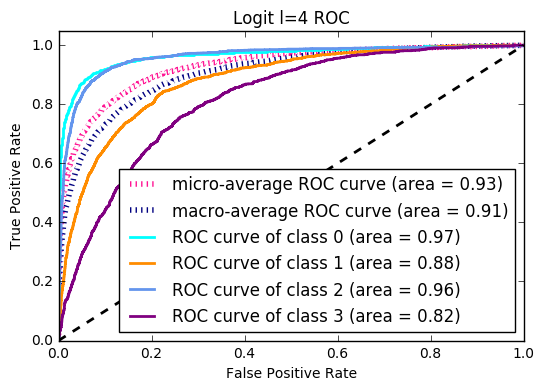

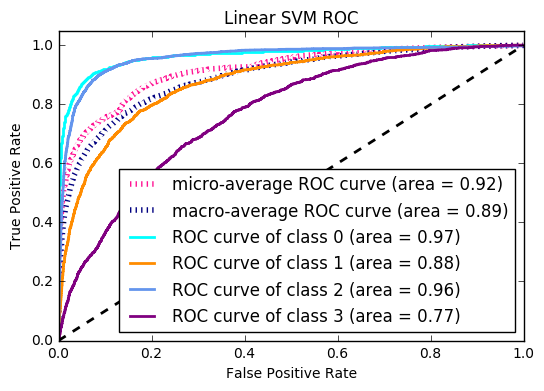

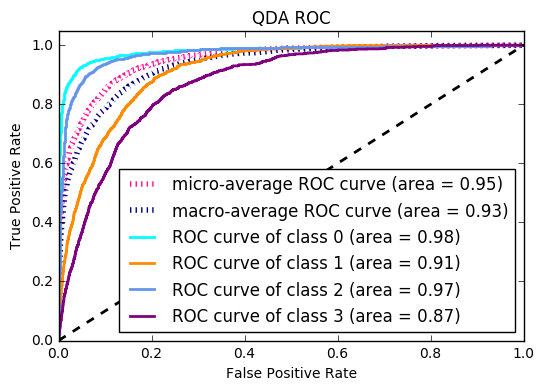

In [65]:
classifiers = [
    ["Logit l=4", LogisticRegression(C=4)],
    #["Rand Forest2", RandomForestClassifier(n_estimators=30, criterion='entropy', max_depth=20, min_samples_leaf=20, 
    #                       bootstrap=True, oob_score=False, random_state=0 )],
    #["GaussianNB",GaussianNB() ],
    ["Linear SVM", SVC(kernel='linear', C=0.5)],
    ["QDA", QuadraticDiscriminantAnalysis()]
]

for name, clf in classifiers: 
    plot_ROC(name, clf)



###  Revisiting our original plan 

From our original list, we were going to: 

* Check that the label counts are balanced. 
    * Balancing data did little to help most models, but did increase bias. I used pandas to undersample by sampling without replacement undersampling, and oversample by sampling with replacements. 
* Transform dimensions using PCA, find separation using LDA 
    * This was very helpful to all models, except for SVM using a non-linear kernel (RBF SVM) 
* Try different lambdas and kernels
    * Decreasing lambda on logit improved model performance, as is expected in models with high bias. 
* Try different complexity of models 
    * More complexity did not help prior to LDA and PCA
    * After LDA and PCA, complexity paid off most notibly in the random forests. Trees up to 20 nodes deep were still accurate. Untransformed inputs did poorly overall in trees, but the simplest trees were relatively better. 
* Rerun the panel of models after each change, and search for the best ones after applying all the changes
    * I am glad that I ran many classifers using the transformed features, including classifiers that performed poorly using untransformed features. It makes sense because some classifiers rely on being able to linearly separate data. 



# Summary code: 

Finally, let's collect together all steps of the process and make predictions 




In [67]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.cross_validation import train_test_split, cross_val_score
import operator 
import numpy as np 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


### Load data in and replace NA->0 
trainX = [] 
with open("/home/lu/Documents/School/81_machine_learning/HW3/HW3/trainingData.txt", 'r') as rp: 
    for line in rp.read().split("\n"): 
        row = line.split("\t") 
        column_i = 0 # cell index 
        for cell in row: 
            try: 
                row[column_i] = float(cell)
            except ValueError: 
                row[column_i] = 0 
            column_i+=1  
        trainX.append(row)
        
        
### Sample some entries from the X data set 
sampleX = np.array(trainX[0:1000])

### Calculate an array of means 
feature_means = np.mean(sampleX, axis=0)

trainX_mean = [] 
with open("/home/lu/Documents/School/81_machine_learning/HW3/HW3/trainingData.txt", 'r') as rp: 
    for line in rp.read().split("\n"): 
        row = line.split("\t") 
        column_i = 0 # cell index 
        for cell in row: 
            try: 
                row[column_i] = float(cell)
            except ValueError: 
                row[column_i] = feature_means[column_i]
            column_i+=1  
        trainX_mean.append(row)
        
trainY = [] 
with open("/home/lu/Documents/School/81_machine_learning/HW3/HW3/trainingTruth.txt", 'r') as rp: 
    for line in rp.read().split("\n"): 
        trainY.append(line)

### Truncate the trailing new lines         
arrayY = np.array(trainY[0:17377])
arrayXm = np.array(trainX_mean[0:17377])

### Perform LDA on all of the available X and Y data, and use 5 fold cross validation to sanity check
X_train = arrayXm 
y_train = arrayY 

lda = LinearDiscriminantAnalysis(n_components=20, solver='eigen', shrinkage='auto')
X_train = lda.fit(X_train, y_train).transform(X_train)

### Fit a QDA model with the transformed training data and training truth 
clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores)

### Load in blind data 
blindX = [] 
with open("/home/lu/Documents/School/81_machine_learning/HW3/HW3/blindData.txt", 'r') as rp: 
    for line in rp.read().split("\n"): 
        row = line.split("\t") 
        i = 0 
        for cell in row: 
            try: 
                row[i] = float(cell)
            except ValueError: 
                row[i] = 0 
            i+=1 
        ### Remove trailing column 
        blindX.append(row[0:334])

### Truncate the last row 
arrayBlind = np.array(blindX[0:20050])


### Transform the blind data 
X_blind = lda.transform(arrayBlind)


### Create predictions 
prob_array = clf.predict_proba(X_blind)

### Write predictions to file 
with open('wang_ochoa_blind_predictions.csv', 'w') as wp: 
    for row in prob_array: 
        index, value = max(enumerate(row), key=operator.itemgetter(1))
        line_list = ["%.3f" % x for x in row] + [str(index+1)] 
        line_str = '\t'.join(line_list)+'\n'
        wp.write(line_str)

[ 0.79413456  0.79113924  0.79539568  0.80023028  0.81375936]
